In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.decoding as dec

In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

In [4]:
%matplotlib notebook

In [272]:
experiment = 'gratings'
trial_epoch = 'stimulus'
responsive_test='nstds'
# --------------------------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-nstds-thr10.00
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [273]:
analysis_type='by_fov'
test_type= None #'size_single'
class_name = 'ori'
match_rfs = False
overlap_thr= None #[0, 0.25, 0.5]

test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)
print(basedir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/default


In [274]:
C_value=1.0
test_split=0.2
cv_nfolds=5
chance_level = 1/8. if experiment=='gratings' else 0.5

## Output dirs

In [275]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)) or match_rfs:
    curr_dst_dir = os.path.join(basedir, 'controls')
else:
    curr_dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/default/dff-nstds__stimulus__noRF__C1.00
dff-nstds__stimulus__noRF__C1.00


## Load

In [276]:
iterdf, missing = dec.load_iterdf(meta, class_name,experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
print(iterdf['overlap_thr'].unique())

(V1) Found 0 paths
(Lm) Found 0 paths
(Li) Found 0 paths


ValueError: No objects to concatenate

In [235]:
print(analysis_type, test_type)
if analysis_type=='by_fov':
    grouper = ['intact', 'visual_area', 'condition', 'datakey']
else:
    grouper = ['intact', 'visual_area', 'condition', 'iteration']
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)):
    grouper.append('overlap_thr')
# if test_type is not None:
#     grouper.append('novel')
# iterdf['intact'] = iterdf['intact'].astype(int)
if analysis_type=='by_fov':
    mean_df = dec.average_across_iterations_by_fov(iterdf,
                        analysis_type=analysis_type, test_type=test_type,
                                                  grouper=grouper)
else:
    mean_df = dec.average_within_iterations_by_ncells(iterdf,
                         analysis_type=analysis_type,
                         test_type=test_type, grouper=grouper) 
if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())

by_fov None
conditions: ['data' 'shuffled']


In [236]:
iterdf.groupby(grouper).mean().reset_index()['intact'].unique()

array([False,  True])

In [237]:
# mean_df.groupby(['condition', 'visual_area', 'intact']).count()

In [238]:
max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
print(max_ncells)
n_iters = iterdf['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells]
xlabels = [1, 32, 96, max_ncells]

87.0


In [254]:
if analysis_type=='by_fov':
    match_ncells=False
    all_counts = mean_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
    max_ncells = all_counts.groupby('visual_area')['n_cells'].max().min() \
                    if match_ncells \
                    else all_counts.groupby('visual_area')['n_cells'].max().max() 
    min_ncells = all_counts.groupby('visual_area')['n_cells'].min().max() \
                    if match_ncells \
                    else 10
    print(min_ncells, max_ncells)
    fov_filter_str = 'matchNcells' if match_ncells else 'allcells'
    passdf = mean_df[(mean_df['n_cells']>=min_ncells) 
                        & (mean_df['n_cells']<=max_ncells)].copy()
    counts = passdf[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
    # Drop repeat FOVs based on N fits
    u_dkeys = aggr.drop_repeats(counts, criterion='max', colname='n_cells')
    finaldf = pd.concat([g for (va, dk), g in passdf.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
    finaldf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()
else:
    finaldf = iterdf[iterdf['n_cells']<=max_ncells].copy()
    max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
    print(max_ncells)

passdf['noise_corrs'] = ['intact' if f else 'shuffled' for f in passdf['intact']]
finaldf['noise_corrs'] = ['intact' if f else 'shuffled' for f in finaldf['intact']]

10 196.0
[V1] Animalid does not exist: JC078 


<IPython.core.display.Javascript object>


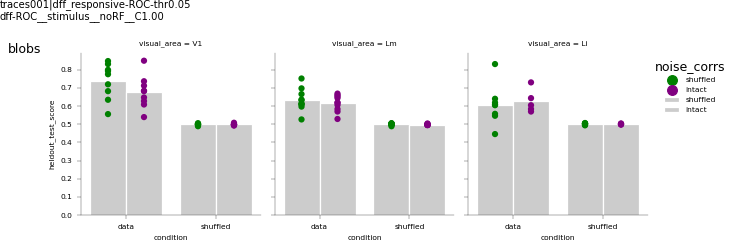

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [264]:
corr_colors = {'intact': 'purple', 'shuffled': 'green'}
g = sns.FacetGrid(data=finaldf, col='visual_area', col_order=visual_areas,
             height=3)
g.map(sns.barplot, 'condition', 'heldout_test_score', 'noise_corrs', ci=None,
     palette={'intact': [0.8]*3, 'shuffled': [0.8]*3}, edgecolor='w')
g.map(sns.stripplot, 'condition', 'heldout_test_score', 'noise_corrs', jitter=False,
     dodge=0.5, palette=corr_colors)
g.fig.axes[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                     title='noise_corrs')
pl.subplots_adjust(bottom=0.2, right=0.8, top=0.8, left=0.1)
pplot.label_figure(g.fig, '%s\n%s' % (data_id, aggr_id))

g.fig.text(0.01, 0.8, experiment)

figname = 'accuracy_noisecorrs_and_shuffled'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [263]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/default/dff-ROC__stimulus__noRF__C1.00'

In [222]:
# mean_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()

#### CONTROL:  Overlap-thr 

In [223]:
cpal = sns.color_palette('viridis', n_colors=4)

In [224]:
%matplotlib notebook
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)) :

    hue_name= 'overlap_thr' #'visual_area'
    subplot_name = 'visual_area' if hue_name=='overlap_thr' else 'overlap_thr'

    overlap_colors = dict((k, v) for k, v in zip(overlap_thr, cpal[0::]))
    curr_palette = area_colors.copy() if hue_name=='visual_area' else overlap_colors.copy()
    # ----------------------------------
    n_iters = finaldf['iteration'].max() +1
    sample_sizes = [s for s in sorted(finaldf['n_cells'].unique()) if s <=max_ncells]
    # plot
    n_subplots=3
    fig, axn = pl.subplots(1, n_subplots, figsize=(6,3), dpi=100, 
                           sharex=True, sharey=True)
    ai = 0
    for ai, (oval, og) in enumerate(finaldf.groupby([subplot_name])):
        ax = axn[visual_areas.index(oval)] if subplot_name=='visual_area' \
                else axn[ai]
        dec.plot_score_v_ncells_color_X(og, sample_sizes, hue_name=hue_name, ax=ax,
                    palette=curr_palette, legend=False)
        ax.axhline(y=chance_level, ls=':', color='k', lw=0.5)
        xlabels = [1, 32, 96, max_ncells]
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
        ax.set_ylim([0.4, 1])
        sns.despine(trim=True)
        title = 'Overlap=%i%%' % (oval*100) if hue_name=='visual_area'\
                    else oval
        ax.set_title(title)
        ai+=1
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    pl.subplots_adjust(bottom=0.15, left=0.1, right=0.85, top=0.75)
    fig.text(0.01, 0.9, 'Accuracy with increasing RF overlap (n=%i iters)' % n_iters)
    pplot.label_figure(fig, data_id)

    figname = 'overlap_hue-%s__%s' % (hue_name, aggr_id)
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
    print(curr_dst_dir, figname)

In [225]:
%matplotlib notebook

if analysis_type=='by_ncells':
    fig, ax = pl.subplots(figsize=(3.5,3), dpi=100, 
                           sharex=True, sharey=True)
    dec.plot_score_v_ncells_color_X(finaldf, sample_sizes, hue_name='visual_area', ax=ax,
                    palette=area_colors, legend=True)
    ax.set_ylim([0., 0.4]) if class_name=='ori' else ax.set_ylim([0.4, 1])
    sns.despine(trim=True)
    fig.text(0.01, 0.87, 'Test scores by_ncells, sd over n=%i iters' % n_iters,
            fontsize=8)
    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

    pl.subplots_adjust(left=0.15, right=0.75, bottom=0.15, top=0.8)
    figname = 'testscore_by_ncells__%s' % aggr_id
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
    print(curr_dst_dir, figname)

In [226]:
cond_colors = {'data': [0.3]*3, 'shuffled': [0.7]*3}

In [231]:
if test_type is not None:
    plotd0 = finaldf[(finaldf['intact'])].copy()
    plotd = plotd0[plotd0['morphlevel']==0]\
                    .groupby(['visual_area', 'datakey', 'novel', 'condition'])\
                    .mean().reset_index()

    hue_column = 'novel' if test_type is not None else 'intact'
    hue_values = sorted(plotd[hue_column].unique())
    cond_colors = {hue_values[0]: [0.3]*3, hue_values[1]: [0.7]*3}    

    metric = 'heldout_test_score'

    %matplotlib notebook
    if analysis_type=='by_fov':
        fig, axn = pl.subplots(1, 2, figsize=(5.5,3), sharex=True, sharey=True)
        for ai, (cond, df_) in enumerate(plotd.groupby('condition')):
            title = 'true_targets' if cond=='data' else 'shuffled_targets'
            ai = 0 if cond=='data' else 1
            ax=axn[ai]; ax.set_title(title)
            sns.barplot(x='visual_area', y=metric, ax=ax, data=df_,
                       hue=hue_column, palette=cond_colors, ci='sd',
                       order=visual_areas)
            ax.legend_.remove()
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                 title=hue_column)
        pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
        ax.set_ylim([0, 1])

        sns.despine(trim=True)
        pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.3)
        figname = 'scores_avg_fov__%s' % aggr_id
        pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
        print(curr_dst_dir, figname)

In [234]:
%matplotlib notebook
cond_colors = {'data': [0.3]*3, 'shuffled': [0.7]*3}    

hue_column = 'novel'
markers={True: 'o', False: 'X'}

if test_type is None:
    maindf = passdf[passdf.condition=='data'].copy()
else:
    maindf = passdf[(passdf.condition=='data') & (maindf.morphlevel==0)].copy()

for is_intact, plotd0 in maindf.groupby(['intact']):
    corr_str = 'intact' if is_intact else 'breakcorr'
    # Mean across train/test transforms (if size single)
    plotd = plotd0.groupby(['visual_area', 'datakey', 'novel']).mean().reset_index()

    fig, axn = pl.subplots(2, 3, figsize=(8,6))
    for ai, metric in enumerate(['heldout_test_score', 'n_cells']):
        ax=axn[0, ai]
        sns.barplot(x='visual_area', y=metric, data=plotd[~plotd.novel], ax=ax, 
                    color=[0.8]*3, ci=None, order=visual_areas)
        sns.stripplot(x='visual_area', y=metric, data=plotd[~plotd.novel], ax=ax,
                    order=visual_areas, size=3,
                    hue='visual_area', palette=area_colors, jitter=False)
        ax.legend_.remove()

    for va, vg in plotd.groupby('visual_area'):
        ax=axn[1, visual_areas.index(va)]
        sns.scatterplot(x='n_cells', y='heldout_test_score', data=vg,
                    ax=ax, color=area_colors[va], s=20, style=hue_column, markers=markers)
        ax.set_ylim([0.4, 1])
        ax.set_xlim([0, 150])
        ax.legend_.remove()
    axn.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                  title=hue_column)
    axn[0, 2].axis('off')
    # ax.legend_.remove()
    pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.8, wspace=0.5, hspace=0.5)
    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
    fig.text(0.01, 0.87, '%s (decode %s: %s)' % (test_str, corr_str, class_name))

    figname = 'accuracy_vs_ncells_%s' % corr_str
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>

AttributeError: 'DataFrame' object has no attribute 'novel'

In [199]:
# passdf[['visual_area', 'datakey', 'n_cells']].drop_duplicates()

In [200]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

In [201]:
# plotd[(plotd.condition=='data') & (plotd.intact) & (plotd.visual_area=='Li')
#      & ~(plotd.novel) & (plotd.morphlevel.isin([0, 16]))]

<IPython.core.display.Javascript object>


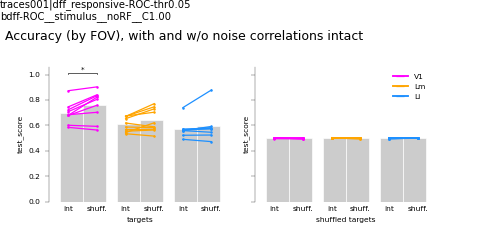

|    |   t_stat |   p_val | visual_area   | condition   |
|---:|---------:|--------:|:--------------|:------------|
|  0 |   -3.162 |   0.013 | V1            | data        |
|  1 |   -2.152 |   0.06  | Lm            | data        |
|  2 |   -1.206 |   0.267 | Li            | data        |
|  0 |    1.211 |   0.261 | V1            | shuffled    |
|  1 |    1.242 |   0.245 | Lm            | shuffled    |
|  2 |   -1.633 |   0.147 | Li            | shuffled    |
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__noRF__C1.00 paired_accuracy_break_noisecorrs


In [211]:
%matplotlib notebook

maindf = finaldf.copy()

plotd = maindf[~(maindf.novel) & (maindf.morphlevel==0)]\
            .groupby(['visual_area', 'datakey', 'noise_corrs', 'condition']).mean()\
            .reset_index()

metric='test_score'
if analysis_type=='by_fov':
    s_=[]
    corr_colors={'intact': 'darkblue', 'shuffled': 'lightblue'}
    fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
    for ai, (cond, datad) in enumerate(plotd.groupby('condition')):
        ax=axn[ai]
        ax, pstats = pplot.pairwise_compare_single_metric(datad, 
                         curr_metric=metric, ax=ax, bar_ci=None,
                         c1='intact', c2='shuffled', compare_var='noise_corrs',
                         return_stats=True, marker='.', size=2, edgecolor=['w']*3,
                         facecolor=[0.8]*3)
        pplot.annotate_sig_on_paired_plot(ax, datad, pstats, metric, lw=0.5,
                                     offset=0.1, h=0.01, fontsize=6)
        pstats['condition'] = cond
        s_.append(pstats)
statsdf = pd.concat(s_, axis=0)
print(statsdf.to_markdown())

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75)
for ai, ax in enumerate(axn):
    ax.set_xlabel('')
    xtick_labels = ['int', 'shuff.']*3
    ax.set_xlabel('targets') if ai==0 else ax.set_xlabel('shuffled targets')
    ax.set_xticklabels(xtick_labels)
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=visual_areas, marker='_')
axn[1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False)
pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))

fig.text(0.01, 0.85, 'Accuracy (by FOV), with and w/o noise correlations intact')

figname = 'paired_accuracy_break_noisecorrs'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [207]:
plotd[(plotd.condition=='shuffled') & (plotd.visual_area=='Li')][['datakey', 'noise_corrs','train_score', 'test_score',  'heldout_test_score']]

,datakey,noise_corrs,train_score,test_score,heldout_test_score
1,20190322_JC073_fov1,intact,0.995941,0.500521,0.500167
3,20190322_JC073_fov1,shuffled,0.999237,0.502669,0.492633
5,20190327_JC073_fov1,intact,0.801570,0.498788,0.498250
7,20190327_JC073_fov1,shuffled,0.804904,0.500253,0.498400
9,20190422_JC076_fov1,intact,0.964381,0.493917,0.493400
11,20190422_JC076_fov1,shuffled,0.977388,0.500452,0.504267
13,20190602_JC091_fov1,intact,1.000000,0.498865,0.499667
15,20190602_JC091_fov1,shuffled,1.000000,0.499611,0.504333
17,20190606_JC091_fov1,intact,0.999864,0.501567,0.503916
19,20190606_JC091_fov1,shuffled,0.999988,0.502000,0.501486


[10.0, 20.0, 30.0, 40.0, 50.0]


<IPython.core.display.Javascript object>


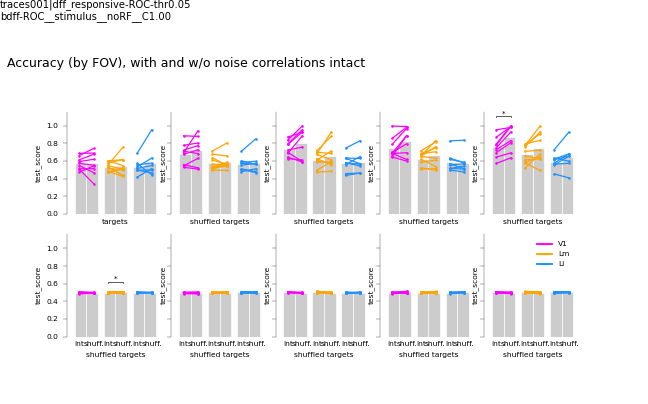

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/morphlevel/morph_single/dff-ROC__stimulus__noRF__C1.00 paired_accuracy_break_noisecorrs_splitTRAIN


In [205]:
%matplotlib notebook

maindf = finaldf.copy()

plotd = maindf[~(maindf.novel) & (maindf.morphlevel==0)]\
            .groupby(['visual_area', 'datakey', 'noise_corrs', \
                      'condition', 'train_transform']).mean().reset_index()
train_transforms = sorted(plotd['train_transform'].unique())
print(train_transforms)
metric='test_score'

fig, axn = pl.subplots(2,len(train_transforms), figsize=(8,5),
                       sharex=True, sharey=True)

for ti, (tcfg, traindf) in enumerate(plotd.groupby(['train_transform'])):

    for ai, (cond, datad) in enumerate(traindf.groupby('condition')):
        ax=axn[ai, ti]
        ax, pstats = pplot.pairwise_compare_single_metric(datad, 
                         curr_metric=metric, ax=ax, bar_ci=None,
                         c1='intact', c2='shuffled', compare_var='noise_corrs',
                         return_stats=True, marker='.', size=2, edgecolor=['w']*3,
                         facecolor=[0.8]*3)
        pplot.annotate_sig_on_paired_plot(ax, datad, pstats, metric, lw=0.5,
                                     offset=0.1, h=0.01, fontsize=6)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75)
for ai, ax in enumerate(axn.flat):
    ax.set_xlabel('')
    #xtick_labels = ['int', 'shuff.']*3
    ax.set_xlabel('targets') if ai==0 else ax.set_xlabel('shuffled targets')
    ax.set_xticklabels(xtick_labels)
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=visual_areas, marker='_')
axn.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False)
pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))

fig.text(0.01, 0.85, 'Accuracy (by FOV), with and w/o noise correlations intact')

figname = 'paired_accuracy_break_noisecorrs_splitTRAIN'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [142]:
cols = ['visual_area', 'datakey', 'noise_corrs', \
                      'condition', 'train_transform', 'train_score', 'test_score', 'heldout_test_score']
# test = maindf[~(maindf.novel) & (maindf.morphlevel.isin[0, 106])] \
#             .groupby(['visual_area', 'datakey', 'noise_corrs', \
#                       'condition', 'train_transform']).mean()
# test.head()

In [180]:
datad[(datad.intact) & (datad.visual_area=='Li')]

,visual_area,datakey,noise_corrs,condition,train_transform,intact,novel,test_transform,morphlevel,fit_time,...,test_score,train_score,heldout_test_score,C,randi,p_chooseB,n_samples,n_trials,iteration,n_cells
9,Li,20190322_JC073_fov1,intact,shuffled,50.0,True,False,50.0,0,0.001013,...,0.506302,0.993029,0.498833,1.0,5029.296,0.503667,6.000,60.0,249.5,38.0
29,Li,20190327_JC073_fov1,intact,shuffled,50.0,True,False,50.0,0,0.002611,...,0.489744,0.797771,0.504083,1.0,4872.406,0.492000,12.000,120.0,249.5,27.0
49,Li,20190422_JC076_fov1,intact,shuffled,50.0,True,False,50.0,0,0.001030,...,0.491751,0.966576,0.491500,1.0,4898.302,0.513333,6.000,60.0,249.5,29.0
69,Li,20190602_JC091_fov1,intact,shuffled,50.0,True,False,50.0,0,0.001110,...,0.501960,1.000000,0.493000,1.0,4998.806,0.503667,6.000,60.0,249.5,87.0
89,Li,20190606_JC091_fov1,intact,shuffled,50.0,True,False,50.0,0,0.000988,...,0.505695,0.999912,0.510923,1.0,5018.906,0.498524,6.494,64.0,249.5,48.0
109,Li,20190607_JC091_fov1,intact,shuffled,50.0,True,False,50.0,0,0.000937,...,0.501662,0.999979,0.488833,1.0,4928.998,0.520667,6.000,60.0,249.5,52.0
129,Li,20190609_JC099_fov1,intact,shuffled,50.0,True,False,50.0,0,0.000896,...,0.505849,1.000000,0.509500,1.0,5008.414,0.497667,6.000,60.0,249.5,57.0
149,Li,20190612_JC099_fov1,intact,shuffled,50.0,True,False,50.0,0,0.001109,...,0.503858,0.997853,0.516167,1.0,5010.000,0.478667,6.000,60.0,249.5,38.0
169,Li,20190614_JC091_fov1,intact,shuffled,50.0,True,False,50.0,0,0.000956,...,0.492689,1.000000,0.485833,1.0,5056.756,0.513000,6.000,60.0,249.5,78.0
189,Li,20191018_JC113_fov1,intact,shuffled,50.0,True,False,50.0,0,0.002489,...,0.501712,0.947406,0.506261,1.0,5051.996,0.492106,11.534,114.0,249.5,47.0


In [144]:
maindf[~(maindf.novel) & (maindf.morphlevel.isin([0, 106]))][cols].drop_duplicates().shape

(840, 8)

In [145]:
840*2.

1680.0

# Example FOV

In [513]:
print(experiment)
dk = '20191006_JC110_fov1'
va = 'V1'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

gratings


In [10]:
# dk = '20190616_JC097_fov1'
# va = 'V1'
print(experiment)
sdf = aggr.get_master_sdf(experiment)

blobs


In [11]:
class_name='morphlevel' if experiment=='blobs' else 'ori'
if experiment=='gratings':
    variation_name = None
else:
    variation_name = None if test_type is None else 'size'
variation_values=None
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None
print(class_name, class_a, class_b)
class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()
in_args={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            'return_clf': False,
            'verbose': False}

morphlevel 0 106


In [514]:
# stimuli
sdf = aggr.get_stimuli(dk, experiment)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [523]:
import copy
inargs = copy.copy(clf_params)

In [525]:
inum=3
test_type=None
i_df = dec.select_test(inum, test_type, ndf_z, sdf, **inargs)
i_df

... 3 - selecting


,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,n_cells,n_trials,iteration
3,0.472028,0.010411,0.255849,0.835691,0.289775,0.094974,0.418057,0.304688,1.0,606,data,93,1280,3
3,1.024186,0.010827,0.127958,0.648679,0.079508,-0.012930,0.114706,0.136719,1.0,606,shuffled,93,1280,3


In [509]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [538]:
neuraldf = ndf_z.copy()
tvals = neuraldf.index.tolist()
neuraldf.loc[neuraldf.index, 'trial'] = tvals         


In [526]:
res = dec.fit_svm_mp(ndf_z, sdf, None, n_iterations=10, n_processes=1,
              **clf_params)

... 0 - selecting
--> Elapsed time: 12.50sec
... 1 - selecting
--> Elapsed time: 12.42sec
... 2 - selecting
--> Elapsed time: 12.68sec
... 3 - selecting
--> Elapsed time: 11.49sec
... 4 - selecting
--> Elapsed time: 13.12sec
... 5 - selecting
--> Elapsed time: 12.25sec
... 6 - selecting
--> Elapsed time: 12.25sec
... 7 - selecting
--> Elapsed time: 11.91sec
... 8 - selecting
--> Elapsed time: 11.87sec
... 9 - selecting
--> Elapsed time: 12.10sec


In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


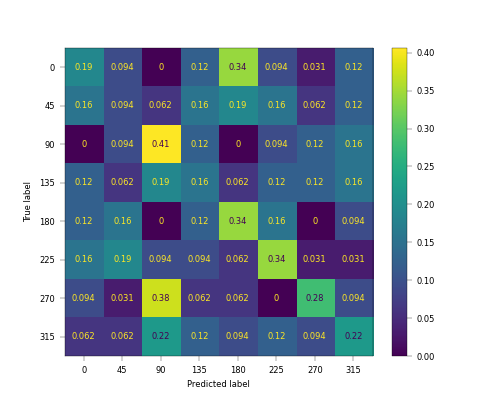

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")